In [1]:
import subprocess
import shlex
import re
import json

import numpy as np
import multiprocessing as mp

from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"non-spatial.{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
import scipy.special as sp

def s_island(A_eff, deme, nu):
    theta_A_eff = (deme * A_eff - 0.0) * nu / (1.0 - nu)
    
    return theta_A_eff * (sp.digamma(theta_A_eff + deme * A_eff) - sp.digamma(theta_A_eff))

def s_island_limit(A_eff, deme, nu):
    return ((A_eff * deme - 0.0) * nu * np.log(1.0 / nu)) / (1.0 - nu)

In [4]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps\.")

In [5]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [6]:
def simulate_non_spatial_scenario(speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: NonSpatial(
            area: ({size[0]}, {size[1]}),
            deme: {size[2]},
            spatial: {str(spatial).lower()},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [7]:
def batch_simulation_many_seeds(simulate, seeds, args=tuple(), kwargs=dict(), silent=False):
    results = []

    with tqdm(total=len(seeds), disable=silent) as progress:
        def update_progress(result):
            results.append(result)

            progress.update()

        with mp.Pool(mp.cpu_count()) as pool:
            for seed in seeds:
                pool.apply_async(simulate, args, {**kwargs, "seed": seed}, update_progress)

            pool.close()
            pool.join()
    
    return results

In [8]:
def confidenceInterval(a, conf=0.95):
    mean = np.mean(a)
    sem = stats.sem(a)
    
    t = stats.t.ppf((1.0 + conf) * 0.5, len(a) - 1)
    
    return mean - t*sem, mean + t*sem

In [9]:
def visualise_biodiversity_time_steps_result(expected, biodiversities, times, steps, conf=0.95):
    low, high = confidenceInterval(biodiversities, conf=conf)

    xmin = np.min(biodiversities)
    xmax = np.max(biodiversities)

    bins = min(21, xmax - xmin + (1 - (xmax - xmin) % 2))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

    ax1.set_title("Biodiversity distribution")
    ax1.set_xlabel("biodiversity")
    ax1.set_ylabel("pdf")
    ax1.hist(biodiversities, bins=bins, density=True, label=(
        f"Observed: {round((low + high) * 0.5, 2)} ± {round((high - low) * 0.5, 2)} ({conf} level)"
    ))
    ax1.axvline(x=expected, color='red', label=f"Expected: {round(expected, 2)}")

    mu, std = stats.norm.fit(biodiversities)
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax1.plot(x, p, 'k', linewidth=2, label=f"Fitted: mu≈{round(mu, 2)} sigma≈{round(std, 2)}")

    ax1.legend(loc = 'lower center')

    ax2.set_title("Simulation time distribution")
    ax2.set_xlabel("time")
    ax2.set_ylabel("pdf")
    ax2.hist(times, bins=bins, density=True)

    ax3.set_title("Simulation steps distribution")
    ax3.set_xlabel("steps")
    ax3.set_ylabel("pdf")
    ax3.hist(steps, bins=bins, density=True)

    plt.show()

# I. Verify correctness of the NonSpatial scenario
## I.1. Verify that the 'dimensions' of the habitat describe a size

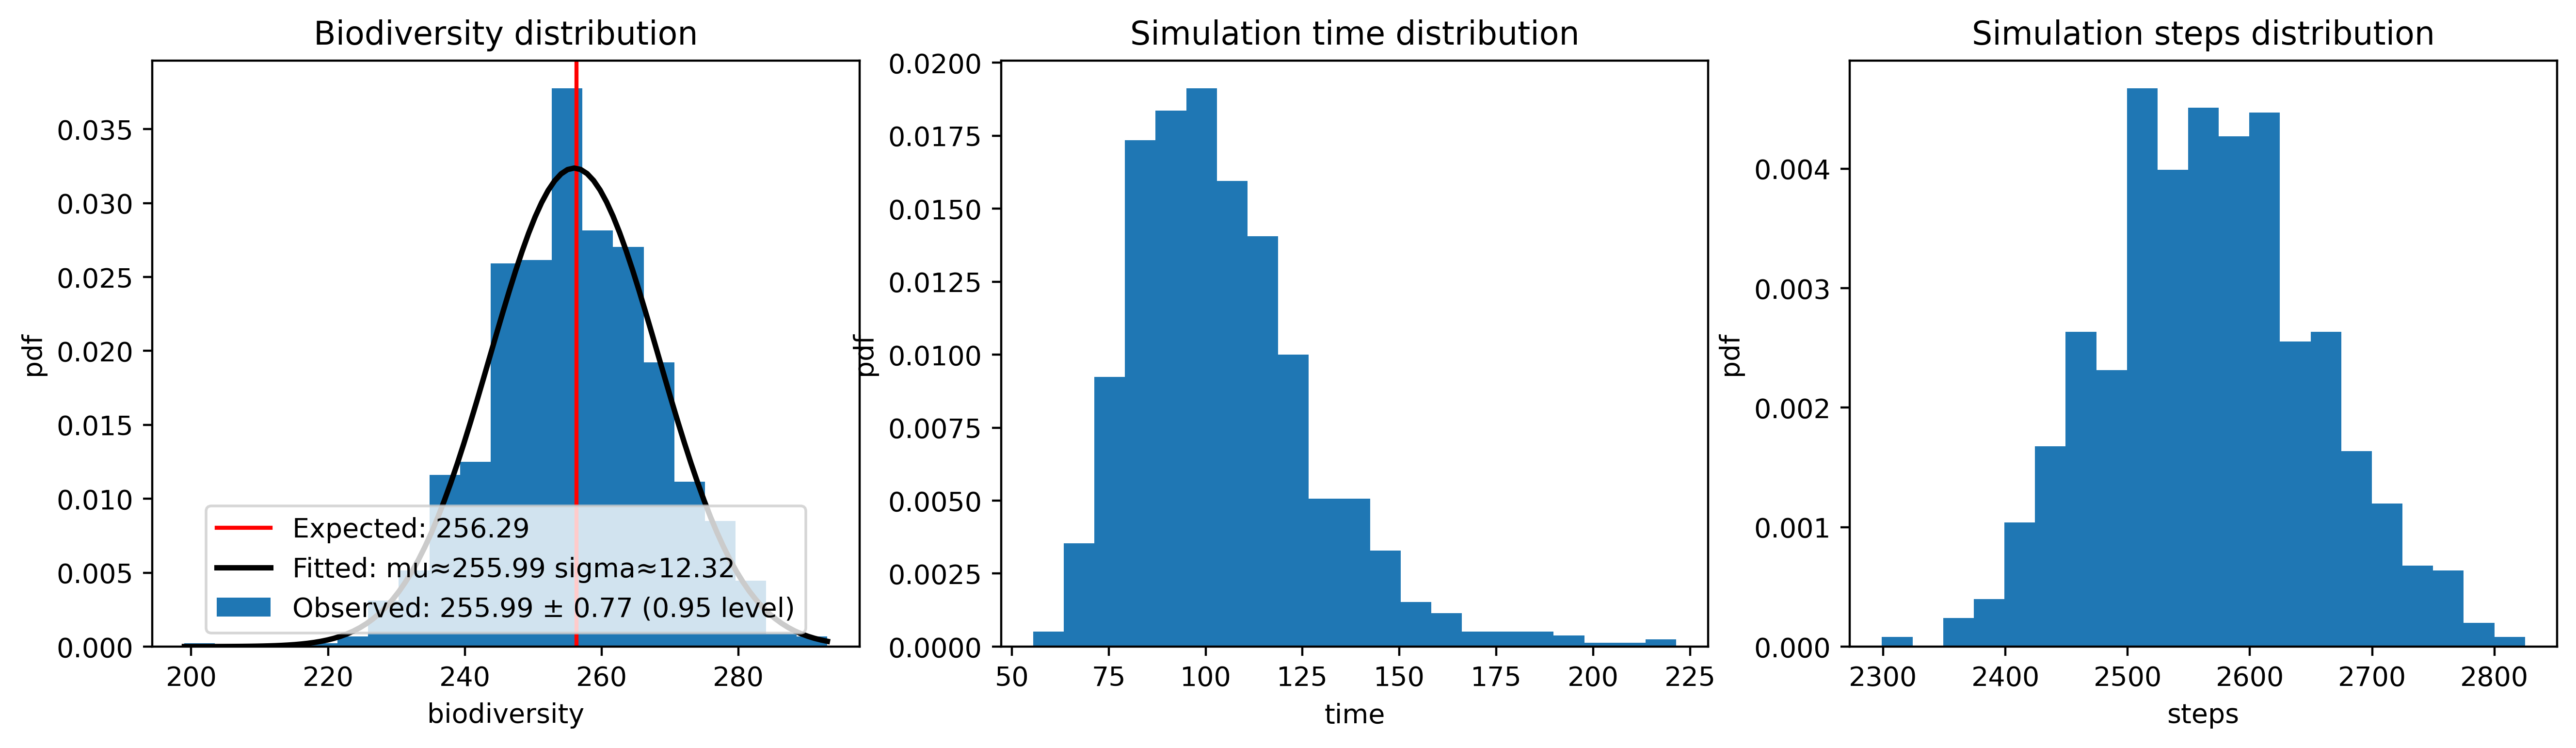

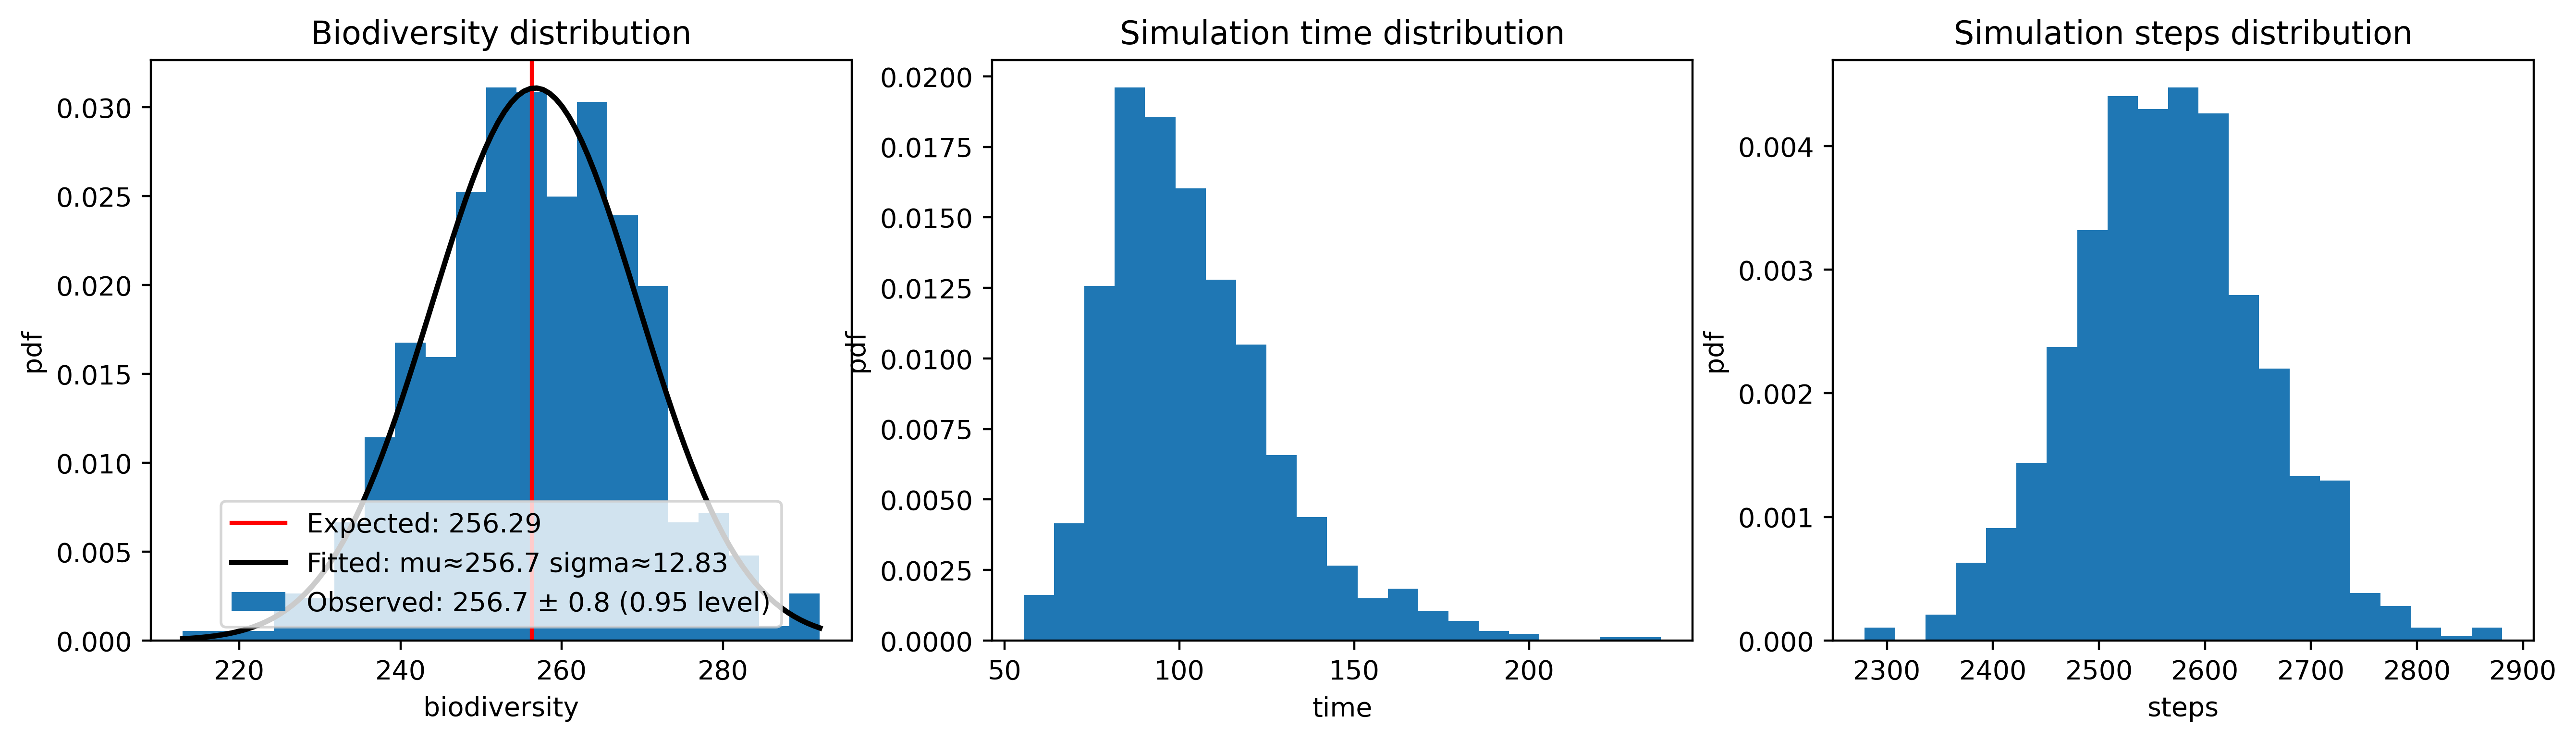

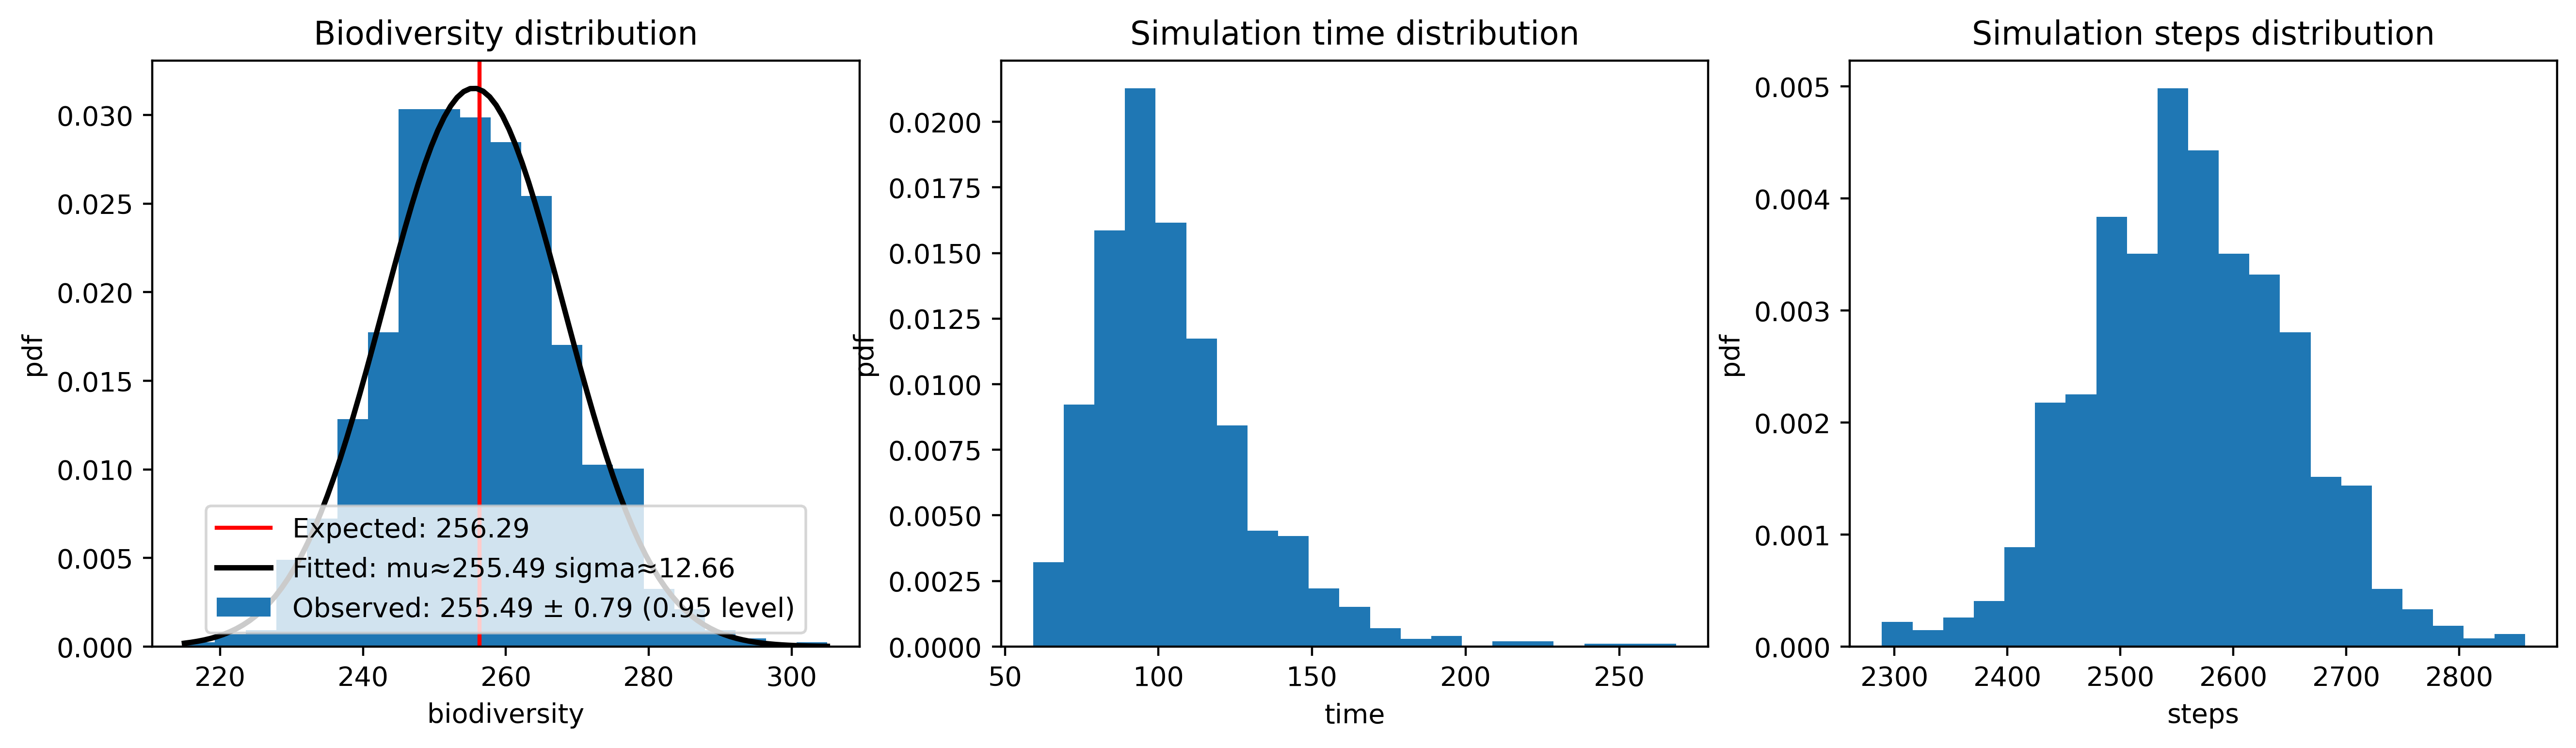

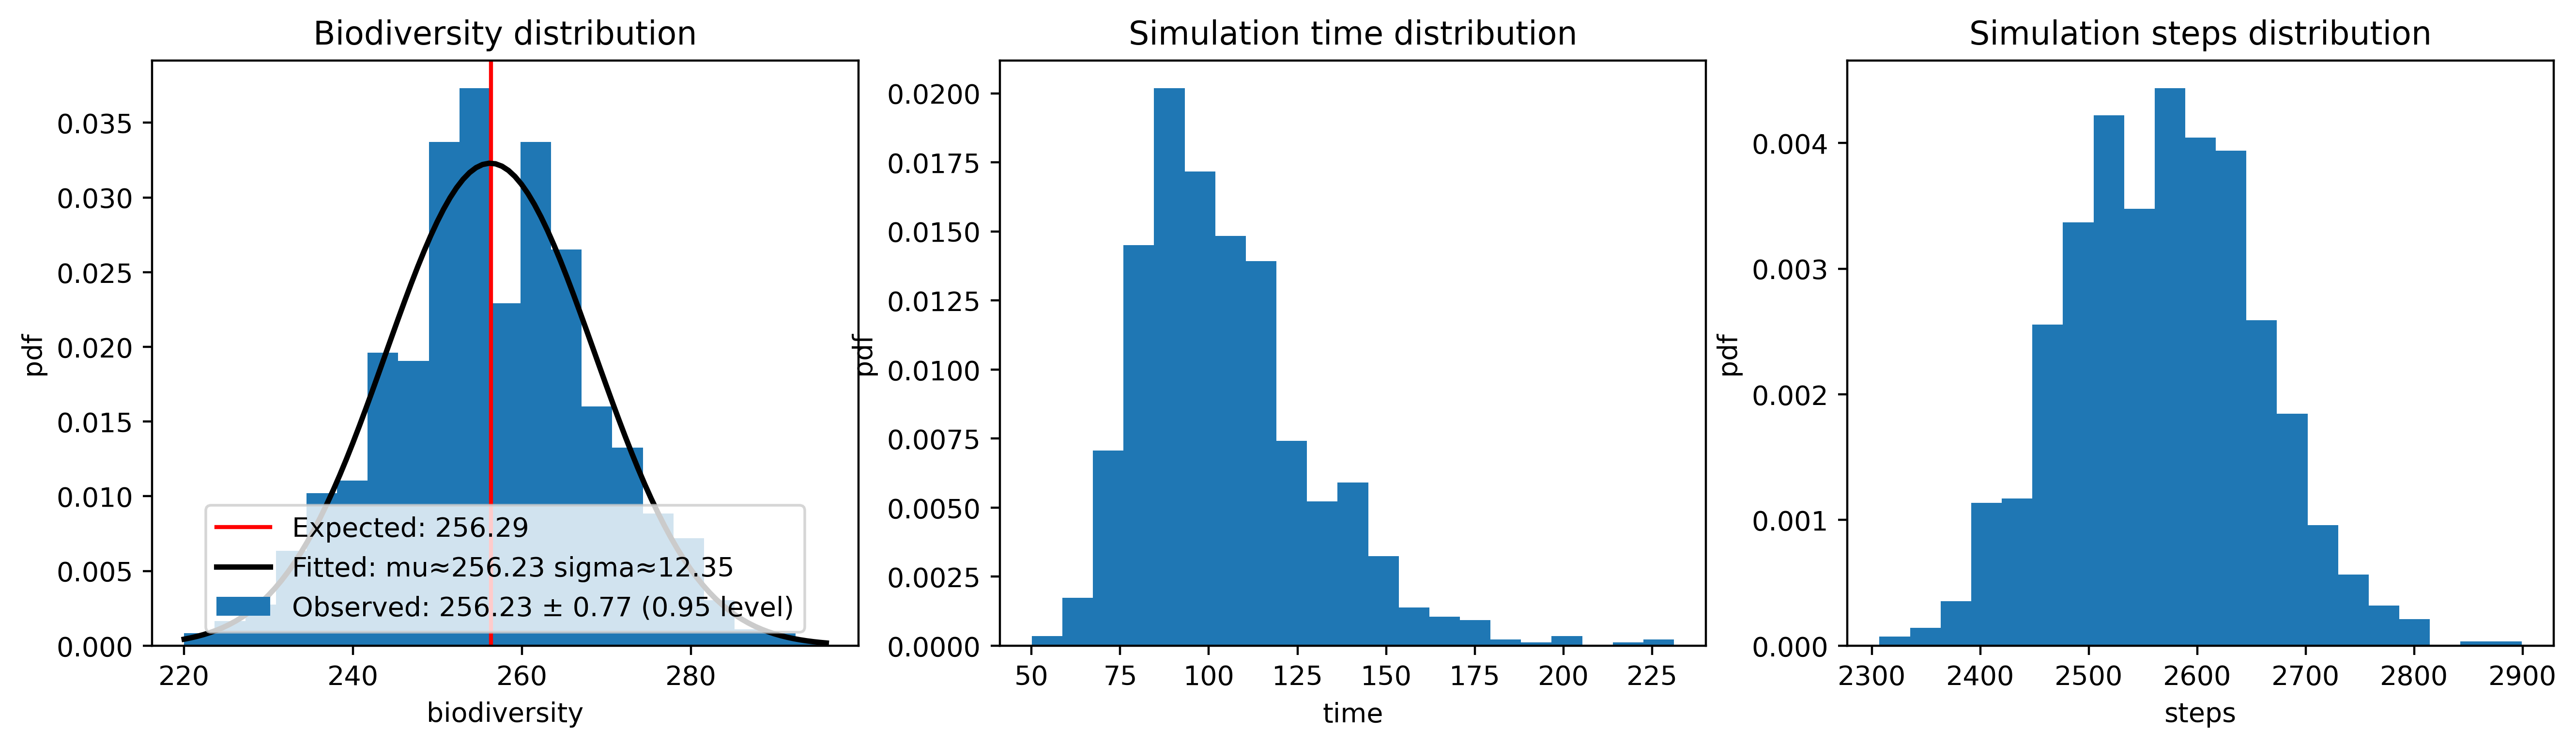

In [10]:
for size in [(10, 10, 10), (1, 100, 10), (10, 1, 100), (100, 10, 1)]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_scenario, seeds, kwargs={"size":size}, silent=True)
    
    biodiversities, times, steps = tuple(zip(*results))
    
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

## I.2. Verify that the `spatial` option does not change the result

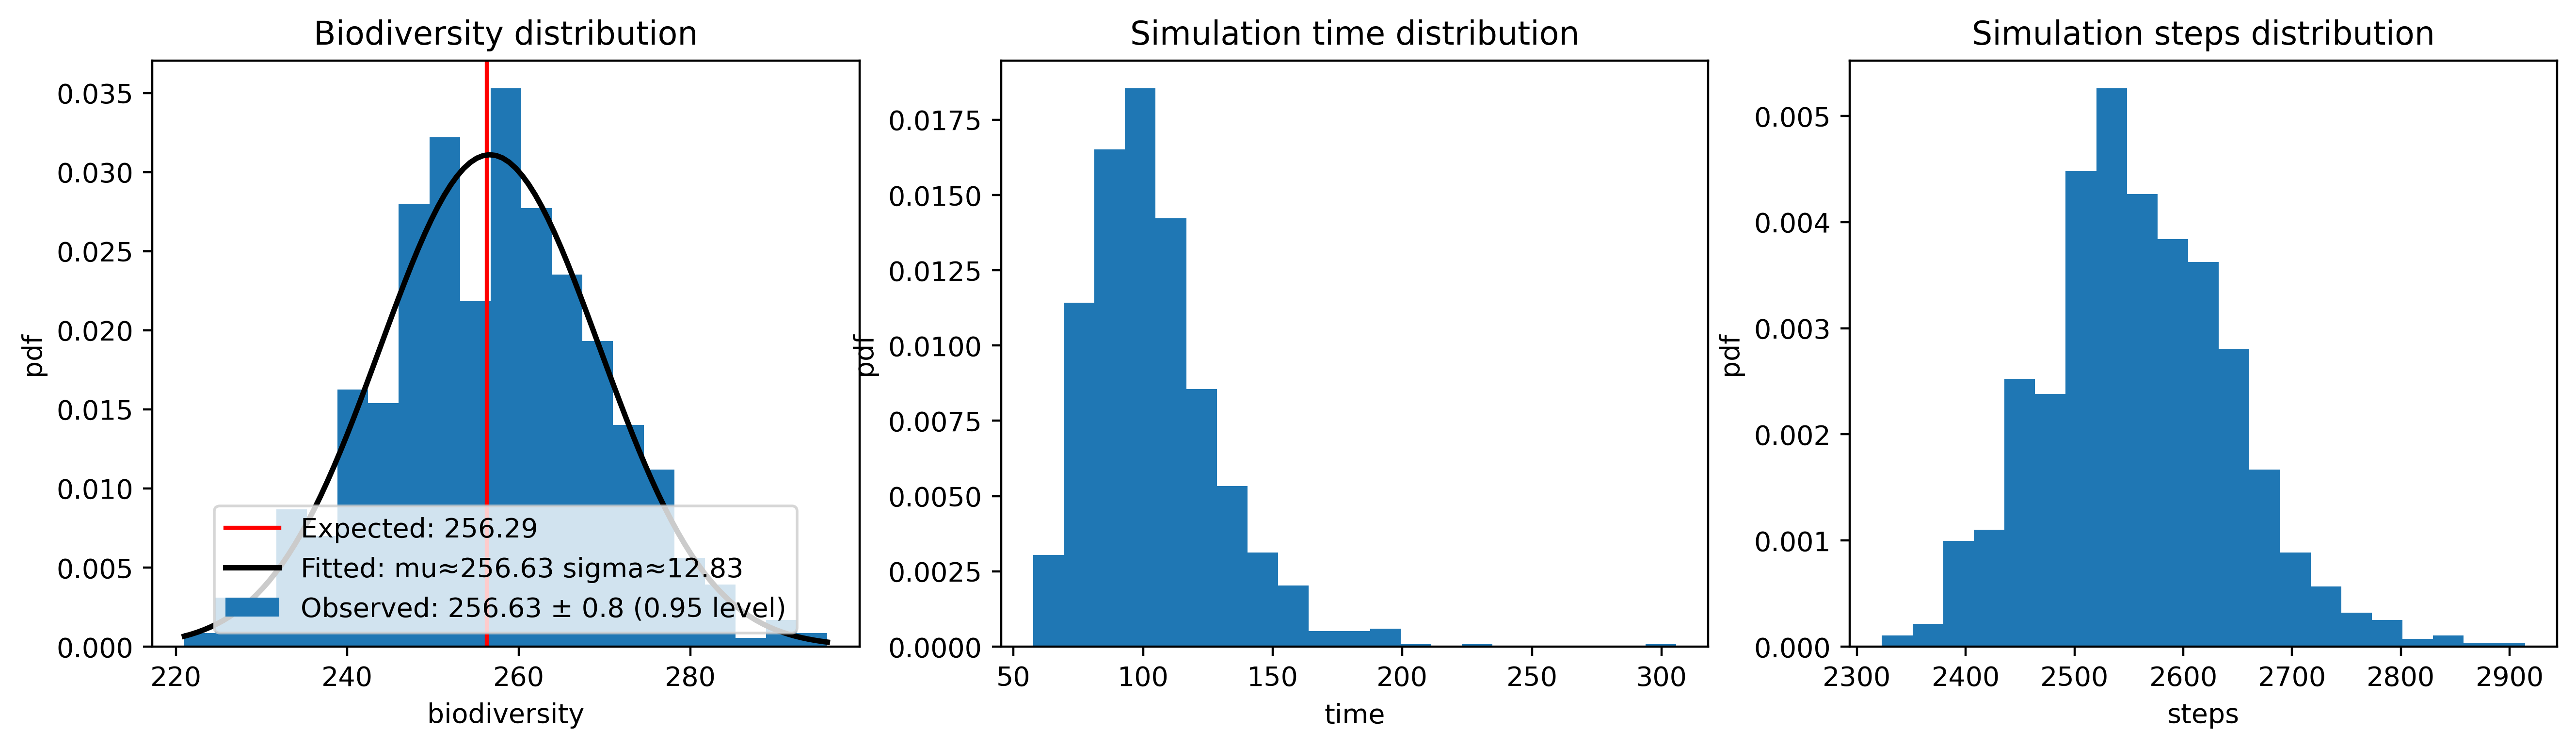

In [11]:
seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

results = batch_simulation_many_seeds(simulate_non_spatial_scenario, seeds, kwargs={"size":size, "spatial":True}, silent=True)

biodiversities, times, steps = tuple(zip(*results))

visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

## I.3. Verify that the `speciation` rate parameter works

/home/ml5717/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


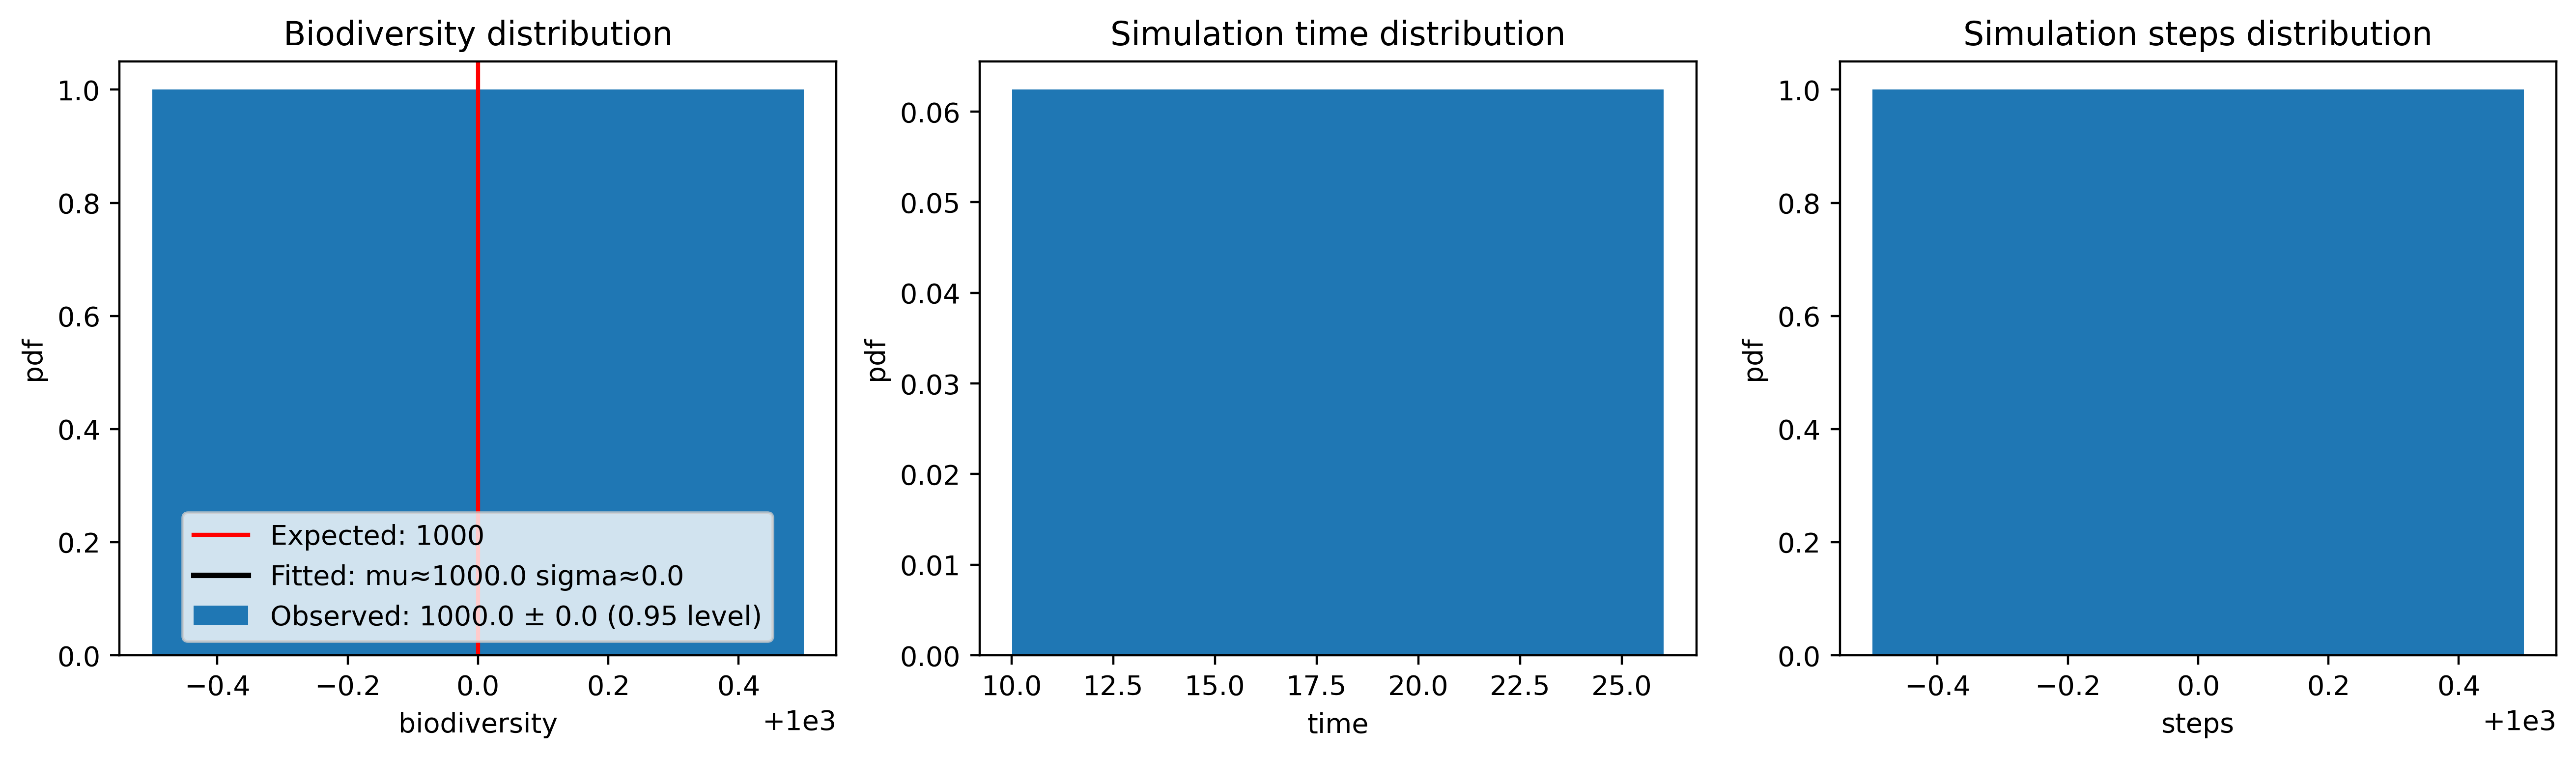

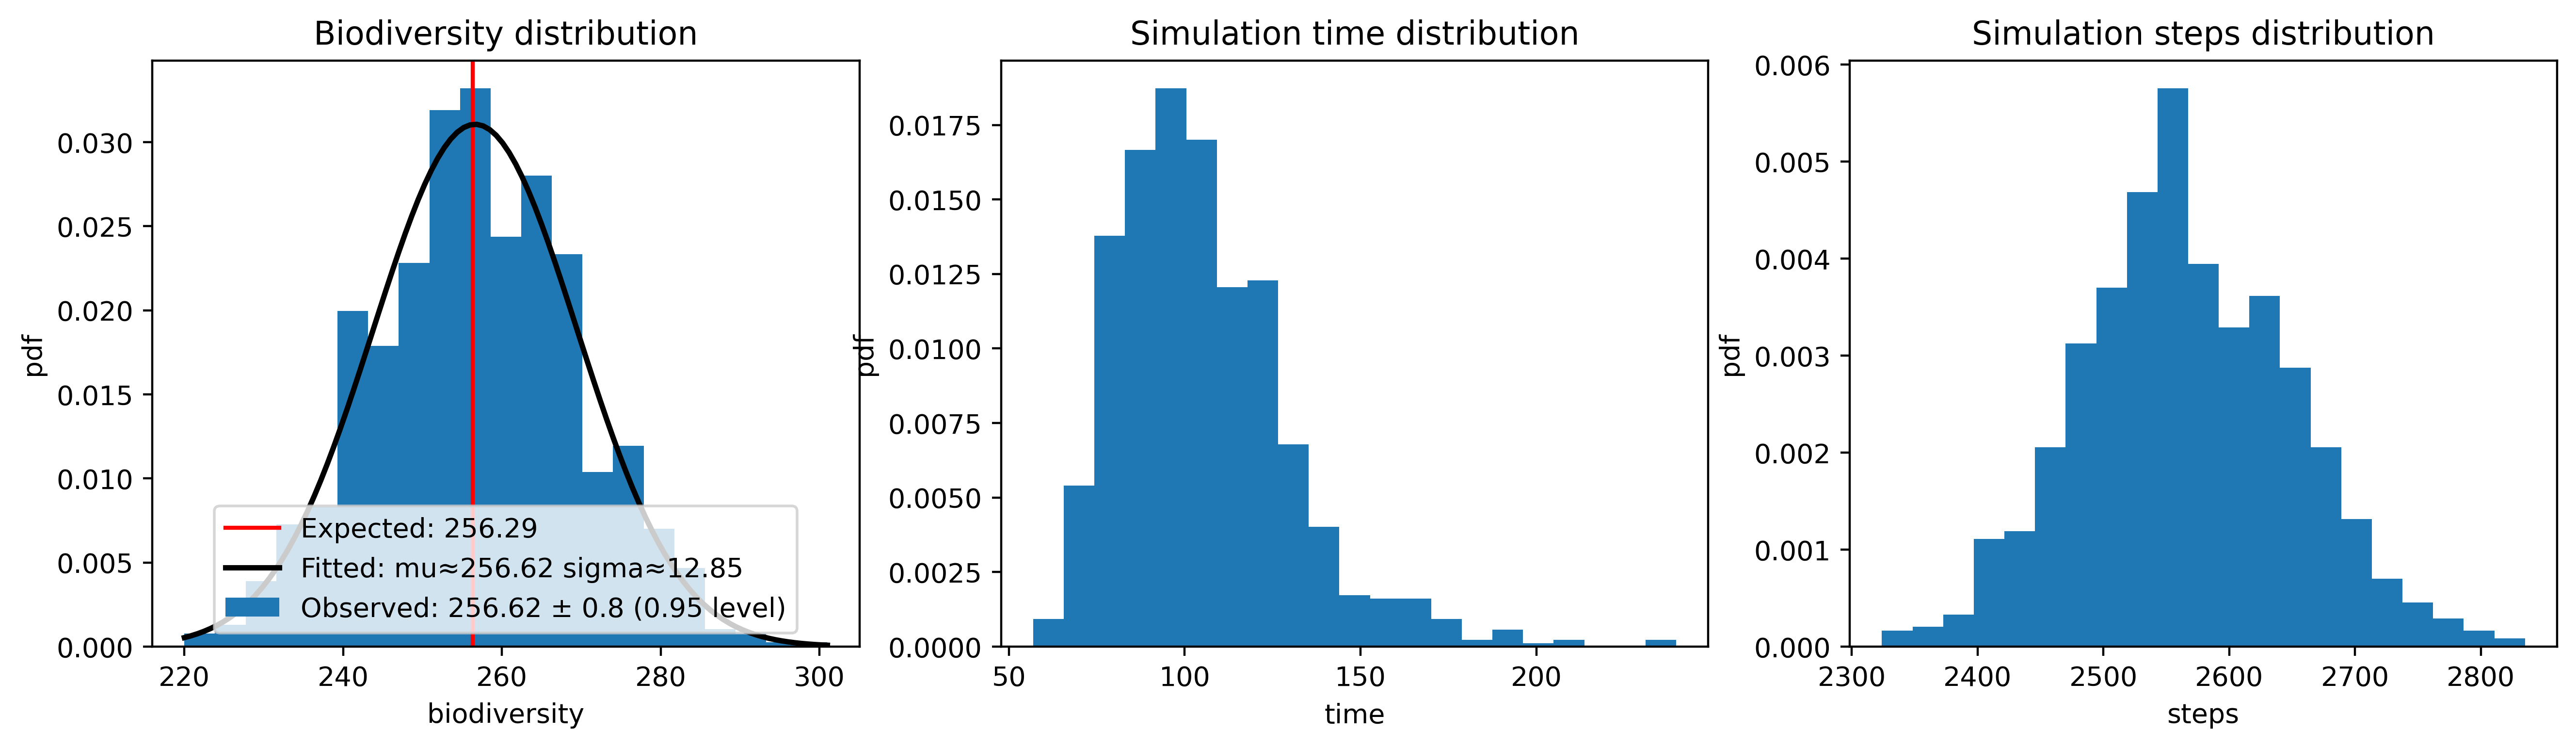

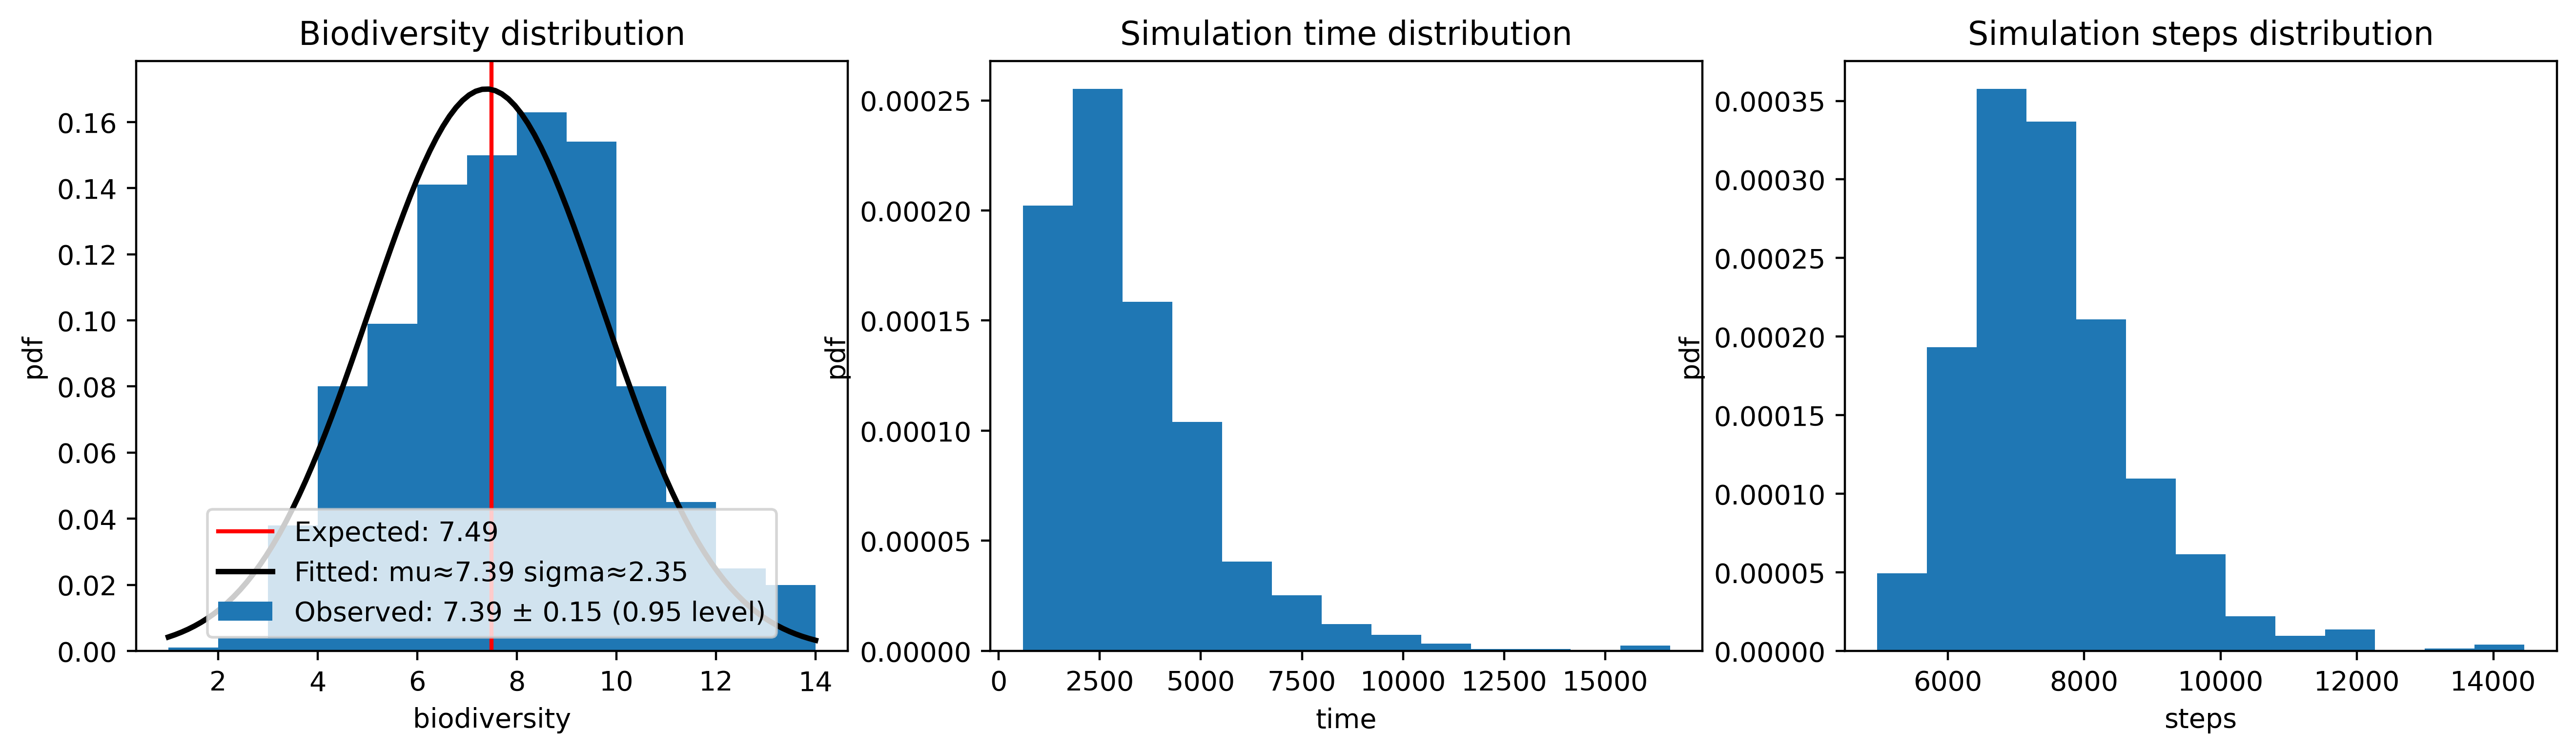

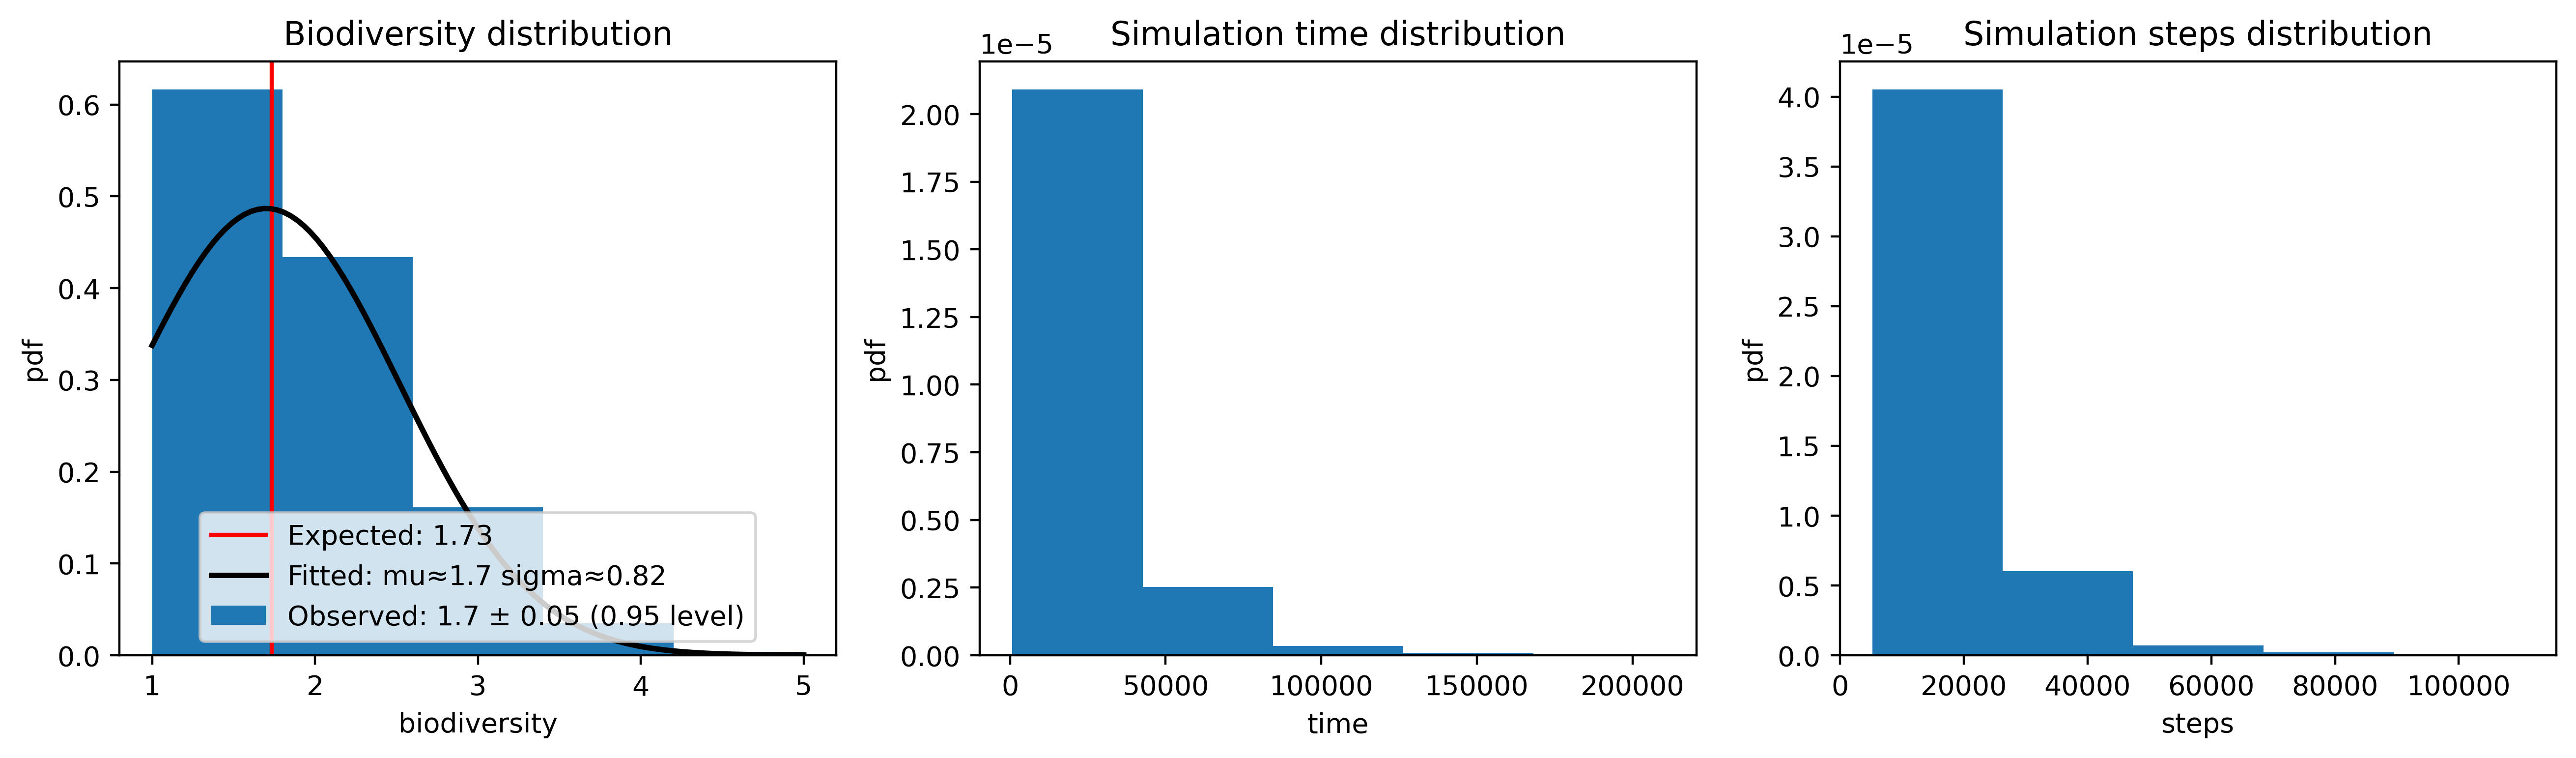

In [12]:
for speciation in [1.0, 0.1, 0.001, 0.0001]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_scenario, seeds, kwargs={"speciation":speciation}, silent=True)
    
    biodiversities, times, steps = tuple(zip(*results))
    
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, speciation) if speciation < 1.0 else 10*10*10, biodiversities, times, steps)